**ส่วนนี้คือการทำ data cleaning (ท่านสามารถดูเพิ่มเติมได้ที่ 1_Data_Cleaning.ipynb)**

**สำหรับการลดขนาดมิติข้อมูลด้วยเทคนิค Principal Component Analysis (PCA) จะเริ่มต่อท้ายหลังจบส่วนนี้**

In [1]:
import sys
sys.version

'3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joblib

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
df = pd.read_parquet('./dataset/train_data.parquet')

#### ทำการเปลี่ยนชนิดข้อมูลให้ถูกประเภท

In [4]:
df['S_2'] = pd.to_datetime(df['S_2'], format='%Y-%m-%d')

In [5]:
category_cols = ['B_30','B_38','D_114','D_116','D_117','D_120','D_126','D_63','D_64','D_66','D_68']

for col in category_cols:
    df[col] = df[col].astype('category')

#### การจัดการกับค่าที่หายไป (Missing Value)

In [6]:
percent_missing = df.isnull().sum() * 100 / len(df)
df_missing_val = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

In [7]:
df.drop(
    columns=df_missing_val.loc[
        df_missing_val.percent_missing > 50
    ].index, inplace=True, errors='ignore'
)

In [8]:
df.dropna(inplace=True)

#### สร้าง dummy variables

In [9]:
df = pd.get_dummies(df, columns=['D_63','D_64','D_68',
                                 'B_30','B_38',
                                 'D_114','D_116','D_117','D_120','D_126'], drop_first=True)
# drop_first=True in order to prevent the Multi-collinearity problem

**การลดขนาดมิติข้อมูลด้วยเทคนิค Principal Component Analysis (PCA) จะเริ่มต้นขึ้นต่อจากนี้**

---

# การลดขนาดมิติข้อมูลด้วยเทคนิค Principal Component Analysis (PCA)

#### เขียนฟังก์ชั่นสำหรับประเมินประสิทธิภาพ model และเก็บค่าไว้ทำกราฟเปรียบเทียบในภายหลัง:

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [11]:
acc = {}; f1 = {}; prec = {}; recl = {}

def my_eval(model,y_test,predicted):
    
    print(model,'Results')
    print('Accuracy: ', accuracy_score(y_test, predicted))
    print('F1 Score: ', f1_score(y_test, predicted))
    print('Precision: ', precision_score(y_test, predicted))
    print('Recall: ', recall_score(y_test, predicted))
    
    acc[model] = accuracy_score(y_test, predicted)
    f1[model] = f1_score(y_test, predicted)
    prec[model] = precision_score(y_test, predicted)
    recl[model] = recall_score(y_test, predicted)
    
    # declair as a global model to ratain the evalutation values along the notebook
    global df_model_compare
    df_model_compare = pd.DataFrame.from_dict(
        [acc,f1,prec,recl]
    ).rename(
        index={0:'Accuracy',1:'F1 Score',2:'Precision',3:'Recall'}
    )
    #display(df_model_compare)

## ทำการแบ่งข้อมูล train/test ด้วยอัตราส่วน 80:20

ในการสร้าง models เพื่อทำนายว่าลูกค้าจะผิดนัดชำระหนี้หรือไม่ จะใช้ปัจจัย (features) ทุกตัวยกเว้น customer_ID เนื่องจากไม่ส่งผลต่อผลลัพธ์และ S_2 เนื่องจากไม่ทราบแน่ชัดว่าคือวันที่ของสิ่งใดและมีความหมายว่าอย่างไร (เนื่องจากชุดข้อมูลนี้ถูกทำให้เป็นแบบนิรนาม (anonymised) มาตั้งแต่ต้น)

กำหนดตัวแปร X (ตัวแปรอิสระ) และ y (ตัวแปรตาม):

In [12]:
X = df.drop(['target','customer_ID','S_2'],axis=1)
y = df['target']

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## ดำเนินการทำ Principal Component Analysis (PCA)

ทำ Principal Component Analysis โดยกำหนดที่ 30 components:

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=30)

In [15]:
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

หลังจากใช้เทคนิค Principal Component Analysis (PCA) แล้ว ทำการล้างตัวแปรต้นฉบับ (X_train, y_train) เพื่อประหยัดหน่วยความจำ:

In [16]:
del X_train
del X_test

## แสดงอิทธิพลของ features เก่าต่อ Principal Component (pc)

Principal Components (pc) คือ components ใหม่ที่สร้างด้วยเทคนิค PCA

โดย index ที่ 0 คือ Principal Component 1 (pc1), index ที่ 1 คือ Principal Component 2 (pc2), และนับต่อไปเรื่อย ๆ

แสดงค่าอิทธิพลของ features เก่าต่อ Principal Component (pc) ใหม่ที่สร้างด้วยเทคนิค PCA:

In [17]:
df_comp = pd.DataFrame(pca.components_, columns=X.columns)
df_comp.T

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
P_2,-1.830243e-03,-0.001031,-0.001129,3.558900e-03,0.010397,-0.038360,0.128951,0.019261,-0.015961,-0.025363,...,0.026600,-0.004221,0.002437,0.019223,-0.007082,0.064037,-0.017070,0.029325,-0.009391,-0.017989
D_39,3.987671e-04,0.000449,0.006315,-1.050599e-03,0.003013,0.012723,-0.022788,0.000289,-0.031987,-0.025466,...,-0.028941,0.037713,-0.031226,-0.007370,0.012164,-0.006095,0.045567,-0.099935,-0.024813,-0.037882
B_1,2.460355e-04,0.000019,-0.000241,-2.501353e-03,-0.006403,0.017790,-0.077776,-0.004577,-0.016885,-0.036679,...,-0.126352,-0.000967,-0.014925,0.006304,-0.017538,0.041176,0.022727,0.004159,-0.018268,-0.035970
B_2,-1.112210e-03,-0.000604,-0.004635,7.742242e-03,0.022920,-0.055270,0.240227,0.032140,0.028977,0.094291,...,0.094492,-0.081612,0.011682,0.020523,0.036238,0.009399,-0.082333,-0.075256,-0.012419,0.051841
R_1,2.724123e-03,0.000483,0.001469,-1.909970e-03,-0.004903,0.043997,-0.065636,0.026549,-0.000260,-0.009159,...,-0.000663,0.033846,0.002244,0.002964,0.007328,-0.003485,0.013744,-0.030313,-0.013222,0.013450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D_117_5.0,4.410513e-07,0.000192,0.000604,7.305321e-04,0.004832,-0.004812,0.030598,0.006339,-0.014841,-0.021968,...,-0.035393,0.010142,-0.018693,-0.001186,-0.056743,-0.000105,0.022385,-0.016467,0.010367,0.005217
D_117_6.0,-8.870179e-05,0.000255,0.001147,7.166724e-04,0.005952,-0.003894,0.023673,0.004409,-0.007268,-0.002165,...,-0.027355,0.011766,-0.007578,0.006674,-0.034326,0.008378,0.016015,-0.012855,-0.008455,0.023459
D_120_1.0,3.903698e-04,0.000237,0.000007,-1.178022e-03,-0.004807,0.013836,-0.052765,-0.005788,0.015649,0.031122,...,-0.015111,0.095921,-0.017744,-0.030028,-0.001072,-0.109768,0.106012,0.013005,0.019186,0.042335
D_126_0.0,-2.222564e-04,-0.000499,-0.000629,8.398922e-07,-0.005113,0.001087,-0.028602,-0.008728,0.057171,0.135696,...,-0.217030,-0.131300,-0.090133,0.250029,0.028891,0.145117,-0.140259,0.059177,0.024675,-0.113750


วาดกราฟแสดงค่าอิทธิพลของ features เก่าต่อ Principal Component (pc) ดังกล่าว:

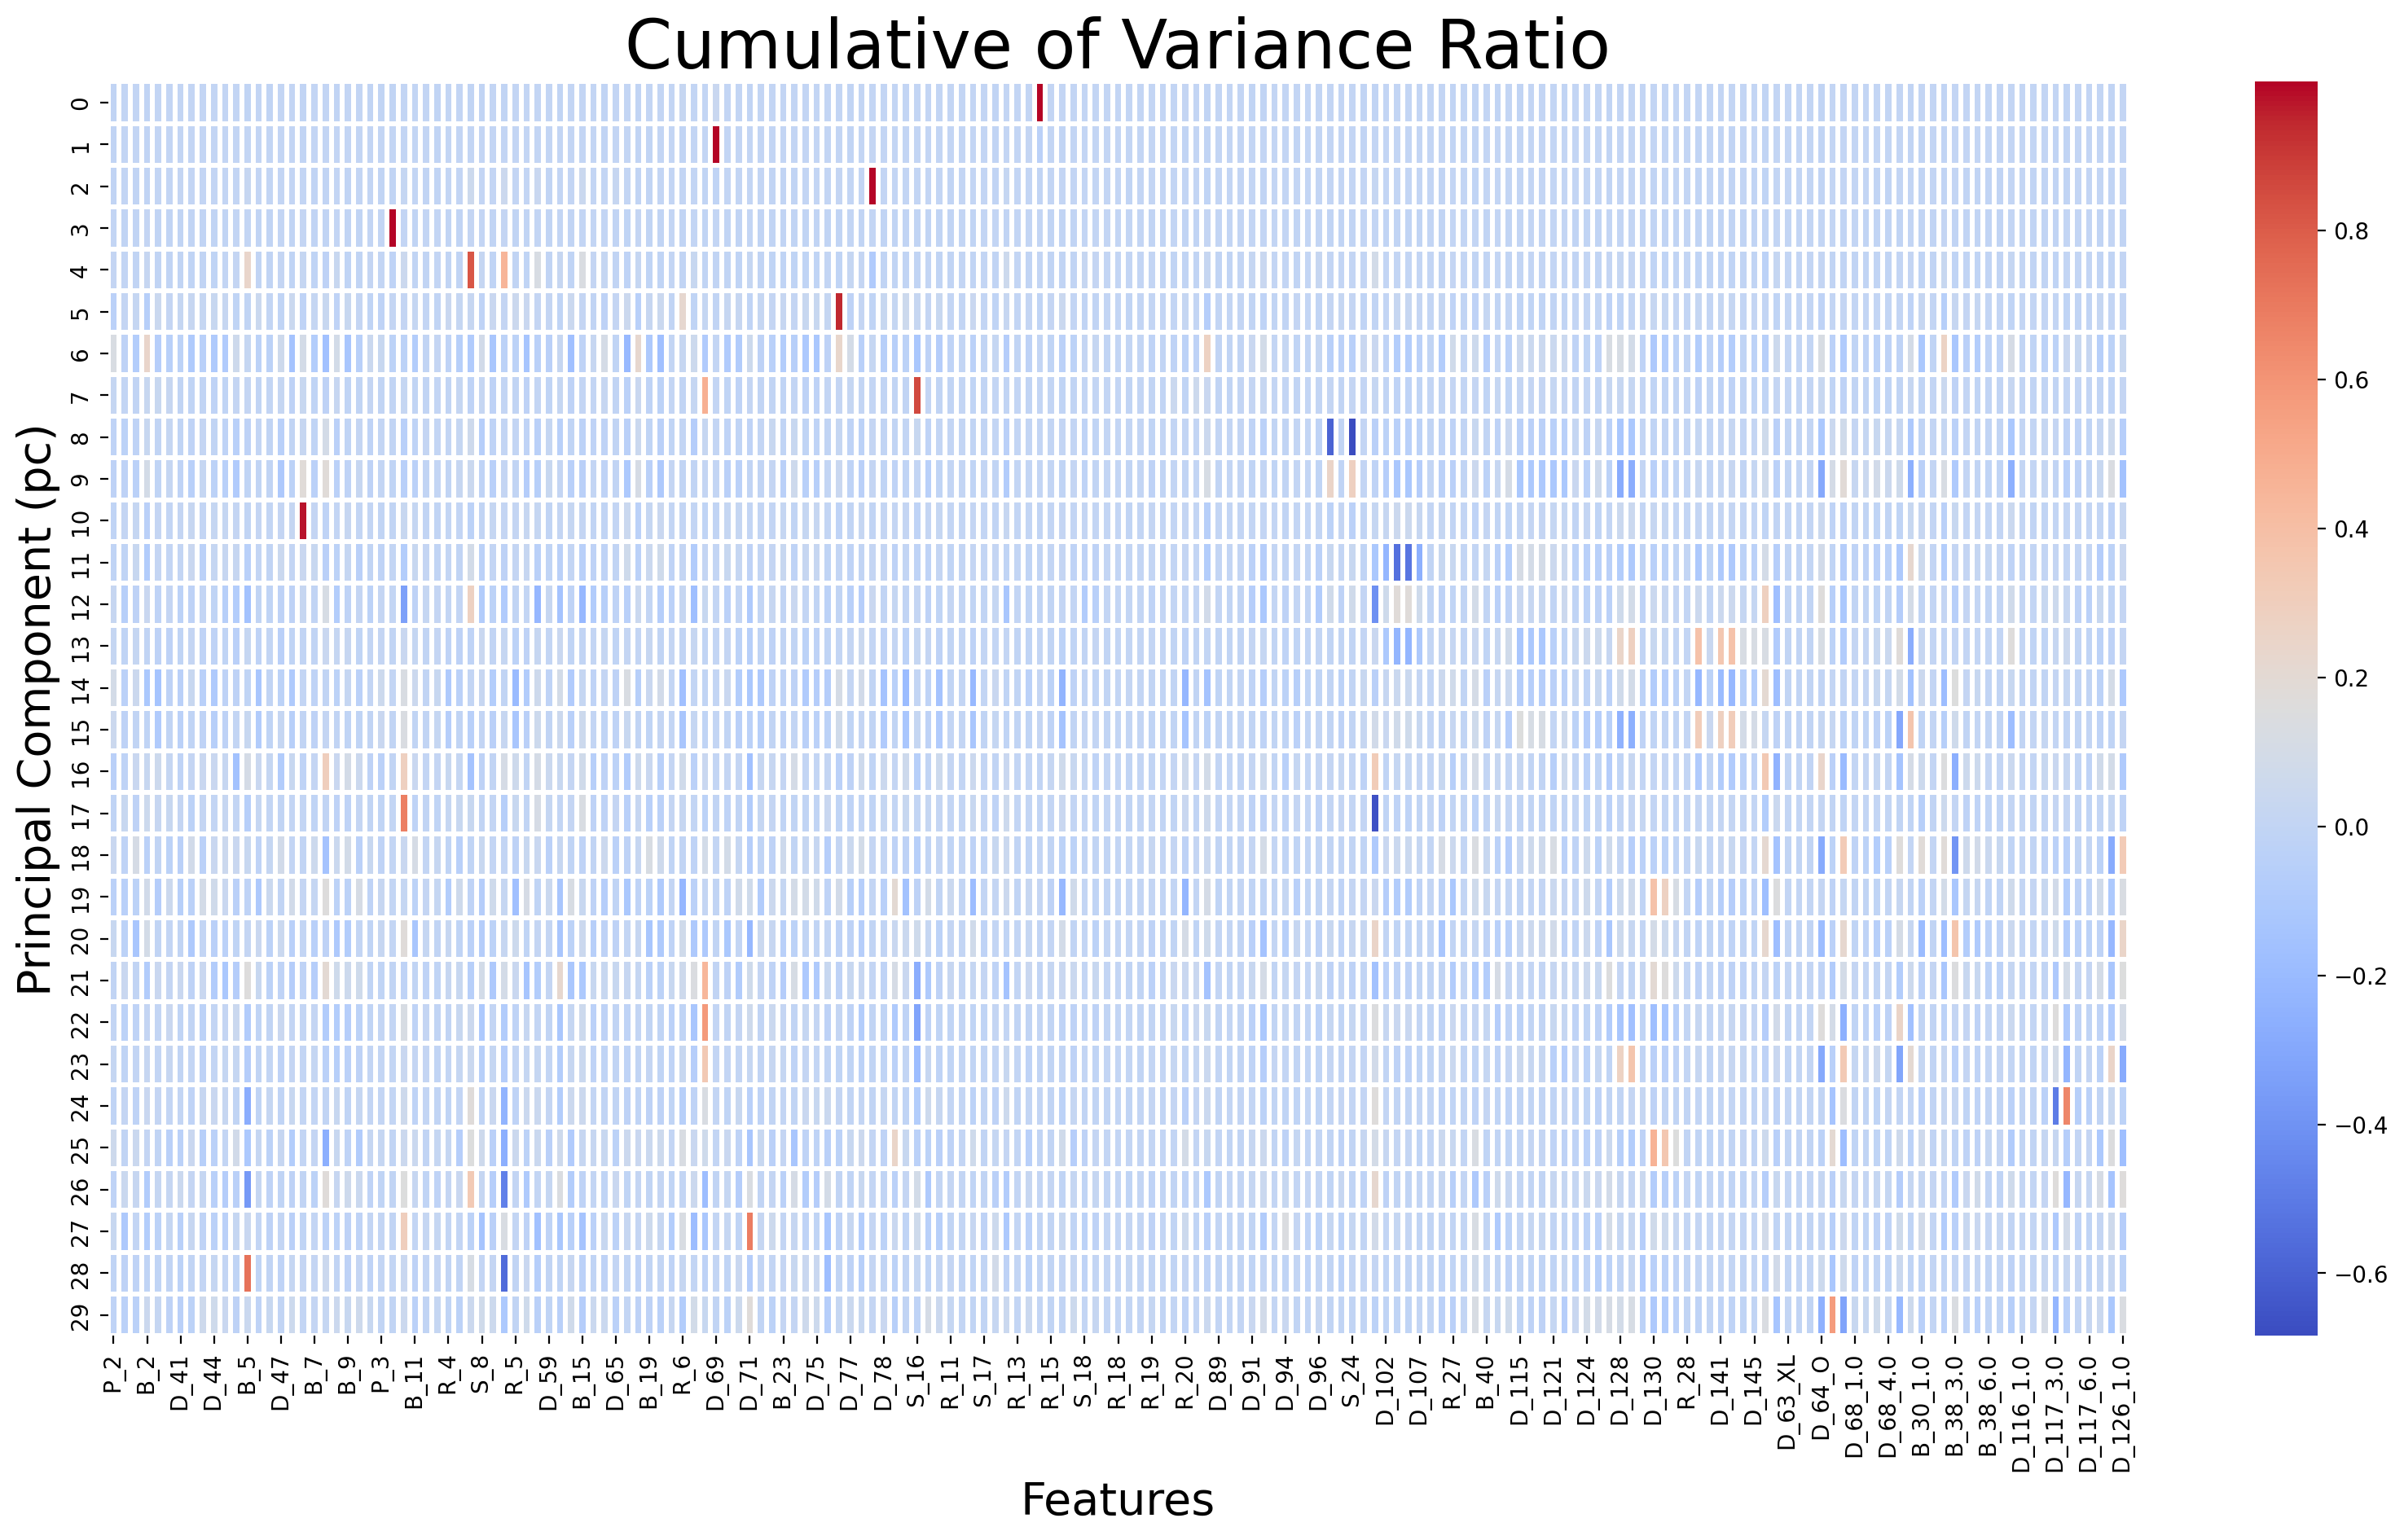

In [18]:
plt.figure(figsize=(20,10))
sns.heatmap(df_comp, annot=False, cmap='coolwarm', linecolor='white', linewidths=2)

plt.xlabel('Features',fontsize=20)
plt.ylabel('Principal Component (pc)',fontsize=20)
plt.title('Cumulative of Variance Ratio',fontsize=30)
plt.show()

ยิ่ง features ใดมีอิทธิพลต่อ principle component มาก สิ่งยิ่งเข้ม หากเป็นสีแดงแสดงว่ามีอิทธิพลไปในทิศทางเดียวกัน (ค่าหนึ่งเยอะ อีกค่าหนึ่งเยอะด้วย) หากเป็นสีน้ำเงินแสดงว่ามีอิทธิพลไปในทิศทางตรงกันข้าม (ค่าหนึ่งเยอะ อีกค่าหนึ่งน้อย)

แสดงค่า variance (แสดงถึงอิทธิพล) ของ principle component เรียงจาก pc1 เป็นต้นไป:

In [19]:
pca.explained_variance_

array([55.68631697, 30.34508061, 10.77821386,  6.78640739,  3.51027801,
        2.41524814,  1.7758698 ,  1.07609589,  0.93383099,  0.84865207,
        0.73785748,  0.58907427,  0.52242336,  0.41335375,  0.39733117,
        0.36761603,  0.35456424,  0.31610813,  0.28088061,  0.2770316 ,
        0.26684966,  0.22889422,  0.22272659,  0.22103872,  0.21315044,
        0.20939151,  0.20662903,  0.19431018,  0.18431173,  0.17869526])

pc1 มี var = 55.17315838 (ยิ่งเลขเยอะ แสดงว่า principle component นั้นยิ่งมีความสำคัญมาก)

แสดงค่า variance สะสม:

In [20]:
pca.explained_variance_ratio_.cumsum()

array([0.44232566, 0.68336167, 0.76897481, 0.82288038, 0.8507631 ,
       0.86994781, 0.88405384, 0.89260145, 0.90001902, 0.90676001,
       0.91262093, 0.91730005, 0.92144974, 0.92473308, 0.92788915,
       0.93080918, 0.93362555, 0.93613645, 0.93836753, 0.94056804,
       0.94268767, 0.94450581, 0.94627497, 0.94803071, 0.9497238 ,
       0.95138703, 0.95302832, 0.95457176, 0.95603578, 0.95745518])

วาดกราฟแสดงค่า variance (อิทธิพลของ features เก่าต่อ Principal Component (pc) ใหม่) สะสม:

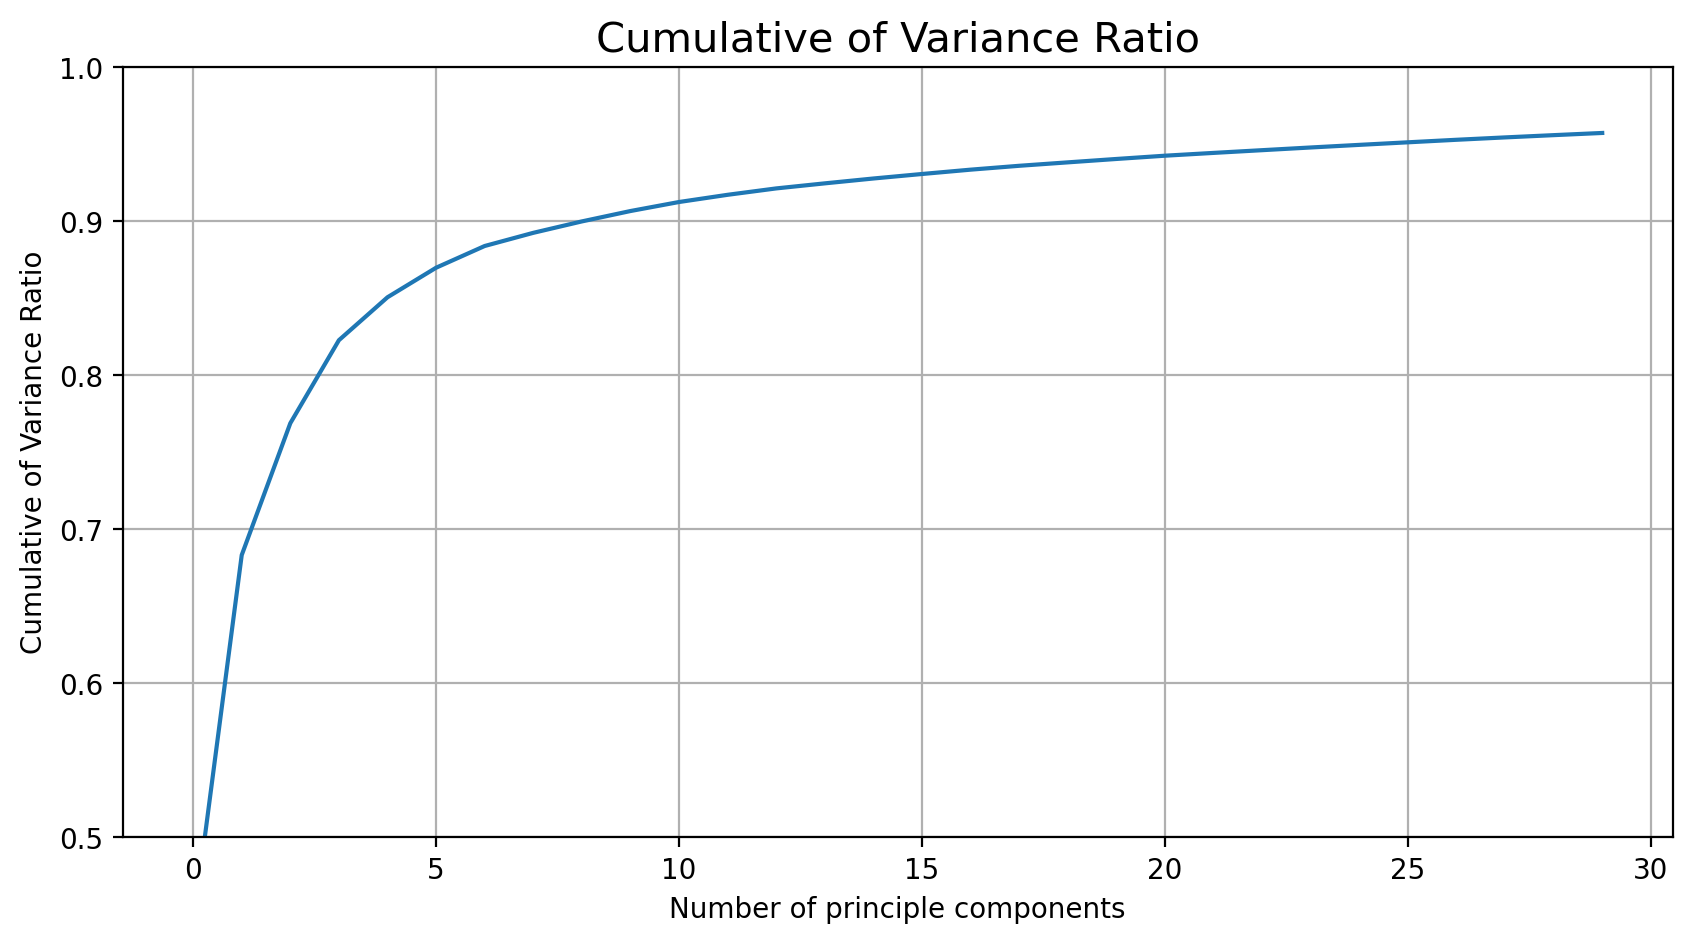

In [21]:
plt.figure(figsize=(10,5))
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.ylim(0.5,1)
plt.xlabel('Number of principle components')
plt.ylabel('Cumulative of Variance Ratio')
plt.title('Cumulative of Variance Ratio',fontsize=15)
plt.grid()

In [22]:
print ( "Components = ", pca.n_components_ , ";\nTotal explained variance = ",
      round(pca.explained_variance_ratio_.sum(),5)  )

Components =  30 ;
Total explained variance =  0.95746


หากใช้ 30 components จะมี variance สะสมอยู่ใน components เหล่านั้นมากถึง 95.7%

ดังนั้น หากใช้ 30 components ก็สามารถครอบคลุมความหมายของข้อมูล (capture information) ได้เพียงพอ  

**สรุป:**

ทำการลดมิติด้วย Principal Component Analysis (PCA) จาก 181 features เหลือ 30 components

## 1) Logistic Regression with PCA

In [23]:
import datetime

แสดง timestamp ก่อนรันอัลกอริทึม:

In [24]:
timer_start = datetime.datetime.now()
print(datetime.datetime.now().time())

21:23:36.668986


สร้าง (ฝึกสอน) model:

In [25]:
from sklearn.linear_model import LogisticRegression

logit_pca = LogisticRegression(max_iter=1000, random_state=42)
logit_pca.fit(X_train_pca, y_train)

LogisticRegression(max_iter=1000, random_state=42)

แสดง timestamp หลังรันอัลกอริทึม:

In [26]:
timer_stop = datetime.datetime.now()
print(datetime.datetime.now().time())

21:23:51.680788


In [27]:
print('The time this algorithm utilised:',timer_stop - timer_start)

The time this algorithm utilised: 0:00:15.011802


**อัลกอริทึมนี้ใช้เวลาทำงานประมาณ 15 วินาที**

สามารถเลือกที่จะบันทึก model ที่จะสร้างใหม่ หรือจะโหลดจาก model ที่สร้างไว้แล้วก็ได้:

In [28]:
# Save Model
joblib.dump(logit_pca, './models/Logit_PCA.pkl')

# Load Model
#logit_pca = joblib.load('./models/Logit_PCA.pkl')

['./models/Logit_PCA.pkl']

ใช้โมเดลทำนาย test set:

In [29]:
logistic_predicted_pca = logit_pca.predict(X_test_pca)

In [30]:
confusion_matrix(y_test, logistic_predicted_pca)

array([[188635,  12622],
       [ 18394,  40673]], dtype=int64)

[ TN FP ]  
[ FN TP ]

TP (ทำนายว่า default; ความจริงคือ default)  
TN (ทำนายว่า non-default; ความจริงคือ non-default)  
FP (ทำนายว่า default; ความจริงคือ non-default)  
FN (ทำนายว่า non-default; ความจริงคือ default)

เรียกฟังก์ชั่นประเมินประสิทธิภาพ model และเก็บค่าไว้ทำกราฟเปรียบเทียบในภายหลัง:

In [31]:
my_eval('Logit_PCA',y_test,logistic_predicted_pca)

Logit_PCA Results
Accuracy:  0.880856163857347
F1 Score:  0.7239636175931365
Precision:  0.76316727647997
Recall:  0.6885909221731255


## 2) Naïve Bayes with PCA

แสดง timestamp ก่อนรันอัลกอริทึม:

In [32]:
timer_start = datetime.datetime.now()
print(datetime.datetime.now().time())

21:23:52.338589


สร้าง (ฝึกสอน) model:

In [33]:
from sklearn.naive_bayes import GaussianNB

nb_pca = GaussianNB()
nb_pca.fit(X_train_pca, y_train)

GaussianNB()

แสดง timestamp หลังรันอัลกอริทึม:

In [34]:
timer_stop = datetime.datetime.now()
print(datetime.datetime.now().time())

21:23:52.935831


In [35]:
print('The time this algorithm utilised:',timer_stop - timer_start)

The time this algorithm utilised: 0:00:00.597242


**อัลกอริทึมนี้ใช้เวลาทำงานประมาณ 1 วินาที**

สามารถเลือกที่จะบันทึก model ที่จะสร้างใหม่ หรือจะโหลดจาก model ที่สร้างไว้แล้วก็ได้:

In [36]:
# Save Model
joblib.dump(nb_pca, './models/NB_PCA.pkl')

# Load Model
#nb_pca = joblib.load('./models/NB_PCA.pkl')

['./models/NB_PCA.pkl']

ใช้โมเดลทำนาย test set:

In [37]:
nb_predicted_pca = nb_pca.predict(X_test_pca)

In [38]:
confusion_matrix(y_test, nb_predicted_pca)

array([[194634,   6623],
       [ 36470,  22597]], dtype=int64)

เรียกฟังก์ชั่นประเมินประสิทธิภาพ model และเก็บค่าไว้ทำกราฟเปรียบเทียบในภายหลัง:

In [39]:
my_eval('NB_PCA',y_test,nb_predicted_pca)

NB_PCA Results
Accuracy:  0.8344639756610992
F1 Score:  0.511898694031964
Precision:  0.7733401779603012
Recall:  0.38256556114243145


## 3) Decision Tree with PCA

แสดง timestamp ก่อนรันอัลกอริทึม:

In [40]:
timer_start = datetime.datetime.now()
print(datetime.datetime.now().time())

21:23:53.687209


สร้าง (ฝึกสอน) model:

In [41]:
from sklearn.tree import DecisionTreeClassifier

dtree_pca = DecisionTreeClassifier(random_state=42)
dtree_pca.fit(X_train_pca, y_train)

DecisionTreeClassifier(random_state=42)

แสดง timestamp หลังรันอัลกอริทึม:

In [42]:
timer_stop = datetime.datetime.now()
print(datetime.datetime.now().time())

21:28:22.727381


In [43]:
print('The time this algorithm utilised:',timer_stop - timer_start)

The time this algorithm utilised: 0:04:29.040172


**อัลกอริทึมนี้ใช้เวลาทำงานประมาณ 5 นาที**

สามารถเลือกที่จะบันทึก model ที่จะสร้างใหม่ หรือจะโหลดจาก model ที่สร้างไว้แล้วก็ได้:

In [44]:
# Save Model
joblib.dump(dtree_pca, './models/DT_PCA.pkl')

# Load Model
#dtree_pca = joblib.load('./models/DT_PCA.pkl')

['./models/DT_PCA.pkl']

ใช้โมเดลทำนาย test set:

In [45]:
dtree_predicted_pca = dtree_pca.predict(X_test_pca)

In [46]:
confusion_matrix(y_test, dtree_predicted_pca)

array([[183325,  17932],
       [ 17612,  41455]], dtype=int64)

เรียกฟังก์ชั่นประเมินประสิทธิภาพ model และเก็บค่าไว้ทำกราฟเปรียบเทียบในภายหลัง:

In [47]:
my_eval('DT_PCA',y_test,dtree_predicted_pca)

DT_PCA Results
Accuracy:  0.8634624544798021
F1 Score:  0.6999341516538066
Precision:  0.6980483944297573
Recall:  0.7018301251121608


## 4) Random Forest with PCA

แสดง timestamp ก่อนรันอัลกอริทึม:

In [48]:
timer_start = datetime.datetime.now()
print(datetime.datetime.now().time())

21:28:23.479555


สร้าง (ฝึกสอน) model:

In [49]:
from sklearn.ensemble import RandomForestClassifier

rf_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pca.fit(X_train_pca, y_train)

RandomForestClassifier(random_state=42)

แสดง timestamp หลังรันอัลกอริทึม:

In [50]:
timer_stop = datetime.datetime.now()
print(datetime.datetime.now().time())

22:21:54.471255


In [51]:
print('The time this algorithm utilised:',timer_stop - timer_start)

The time this algorithm utilised: 0:53:30.991700


**อัลกอริทึมนี้ใช้เวลาทำงานประมาณ 54 นาที**

สามารถเลือกที่จะบันทึก model ที่จะสร้างใหม่ หรือจะโหลดจาก model ที่สร้างไว้แล้วก็ได้:

In [52]:
# Save Model
joblib.dump(rf_pca, './models/RF_PCA.pkl')

# Load Model
#rf_pca = joblib.load('./models/RF_PCA.pkl')

['./models/RF_PCA.pkl']

ใช้โมเดลทำนาย test set:

In [53]:
rf_predicted_pca = rf_pca.predict(X_test_pca)

In [54]:
confusion_matrix(y_test, rf_predicted_pca)

array([[190720,  10537],
       [ 12842,  46225]], dtype=int64)

เรียกฟังก์ชั่นประเมินประสิทธิภาพ model และเก็บค่าไว้ทำกราฟเปรียบเทียบในภายหลัง:

In [55]:
my_eval('RF_PCA',y_test,rf_predicted_pca)

RF_PCA Results
Accuracy:  0.910192682964306
F1 Score:  0.7981593556017923
Precision:  0.8143652443536169
Recall:  0.7825858770548699


---

In [56]:
display(df_model_compare)

,Logit_PCA,NB_PCA,DT_PCA,RF_PCA
Accuracy,0.880856,0.834464,0.863462,0.910193
F1 Score,0.723964,0.511899,0.699934,0.798159
Precision,0.763167,0.773340,0.698048,0.814365
Recall,0.688591,0.382566,0.701830,0.782586


บันทึกค่าประเมินประสิทธิภาพของแต่ละ model เพื่อใช้เปรียบเทียบใน notebook ชื่อ 5_Comparison.ipynb:

In [57]:
df_model_compare.to_csv('./eval_results/eval_results_PCA.csv')